# Readout
Using a RF classifier as the meta model didn't help (made the accuracy worse). Probably because they are the same models (meta and ovr models), so some of the information is lost or confused somehow. Will deprecate this and move on to a more diverse multi model.

# To-Do:
- [x] Make the train_test_split same for all three sub-models.
- [ ] correct whatever issues there are in the split. fix it by recreating from scratch.
    - create splits using 'Target' as stratify in both splits to preserve distribution and then drop extra columns from the arrays.

# Student Success and Failure Lookalike Project

School is one of the best ways to raise individuals' earnings potentials. If we can identify students who are at risk in school, it's possible we could intervene beforehand. If we can identify "lookalike's" of students that fail, we could intervene with these students and tailor solutions based on identifiers.

_"A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. The dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. The data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes._

_Data Source: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success_

This dataset was provided by the Polytechnic Institute of Portalegre and SATDAP - Capacitação da Administração Pública.

Citation: M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

Note: While this group certainly did their own prediction, I have not and will not read the paper until after I complete my own data model.

<div style="margin-left: 50px;">
    <img src="./poly_screenshot.png" width="600" />
</div>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, RocCurveDisplay, accuracy_score, precision_score, recall_score
from numpy import log1p, arange, where
from pandas import Series, DataFrame
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

SD = 42

In [2]:
#pulling in the data for an initial first pass
datapath = './data/student_data.csv'
raw_df = pd.read_csv(datapath, low_memory=False, delimiter=';')
print(raw_df.shape)

(4424, 37)


In [3]:
le = LabelEncoder()
le.fit(raw_df['Target'])
target_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Target Column Conversion: {target_map}")

def target_mapping(x):
    #Pulls out the number order of the item and assigns it
    y = target_map[x]
    return(y)

raw_df["Target"] = raw_df["Target"].apply(target_mapping)
raw_df['dropout'] = np.where(raw_df["Target"]==0,1,0)
raw_df['enrolled'] = np.where(raw_df["Target"]==1,1,0)
raw_df['graduate'] = np.where(raw_df["Target"]==2,1,0)
display(raw_df.head(10))

Target Column Conversion: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,dropout,enrolled,graduate
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0.000000,0,10.8,1.4,1.74,0,1,0,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,13.666667,0,13.9,-0.3,0.79,2,0,0,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0.000000,0,10.8,1.4,1.74,0,1,0,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,5,12.400000,0,9.4,-0.8,-3.12,2,0,0,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,13.000000,0,13.9,-0.3,0.79,2,0,0,1
5,2,39,1,9991,0,19,133.1,1,37,37,...,5,11.500000,5,16.2,0.3,-0.92,2,0,0,1
6,1,1,1,9500,1,1,142.0,1,19,38,...,8,14.345000,0,15.5,2.8,-4.06,2,0,0,1
7,1,18,4,9254,1,1,119.0,1,37,37,...,0,0.000000,0,15.5,2.8,-4.06,0,1,0,0
8,1,1,3,9238,1,1,137.0,62,1,1,...,6,14.142857,0,16.2,0.3,-0.92,2,0,0,1
9,1,1,1,9238,1,1,138.0,1,1,19,...,2,13.500000,0,8.9,1.4,3.51,0,1,0,0


In [26]:
#split out a test set based on Target; stratify each split based on the Target distribution.
#X_temp, X_test, y_temp, y_test = train_test_split(raw_df, raw_df['Target'], stratify=raw_df['Target'], test_size=0.2, random_state=SD)
#X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=SD)

#Split into two sets of data, 1 for train/test of 1vR models; 1 for train/test of multi model
X_ovr, X_multi, y_ovr, y_multi = train_test_split(raw_df, raw_df['Target'], stratify=raw_df['Target'], test_size=0.5, random_state=SD)

#1vR train/test
X_train, X_val, y_train, y_val = train_test_split(X_ovr, y_ovr, stratify=y_ovr, test_size=0.2, random_state=SD)
#Multi
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, stratify=y_multi, test_size=0.2, random_state=SD)



# Dropout - 0

In [27]:
#Split
#y = raw_df['dropout']
#real_labels = raw_df['Target']
#X = raw_df.drop(["Target", "enrolled","graduate","dropout"], axis=1)

#do_X_train, do_X_val, do_y_train, do_y_val = splitter(X,y)

#display(do_X_train.head())


##Create the GB model using 1's and 0's for dropouts
#do_GB = GradientBoostingClassifier(class_weight='balanced')
#do_GB.fit(X=do_X_train, y=do_y_train)
##score
#do_y_preds = do_GB.predict(do_X_val)
#print(f"GB Accuracy: {accuracy_score(do_y_val, do_y_preds)}")
#rmse = mean_squared_error(do_y_val, do_y_preds)**(1/2)
#print(f"GB RMSE: {rmse}")
#prec_rec = precision_score(do_y_val, do_y_preds), recall_score(do_y_val, do_y_preds)
#print(f"Precision/Recall: {prec_rec}")
##display(pd.DataFrame({'vals':do_y_val, 'preds':do_y_preds}))
##test_preds = do_GB.predict(X_test.drop(['Target','dropout','enrolled','graduate'],axis=1))
##test_prec_rec = precision_score(y_test, test_preds), recall_score(y_test, test_preds)
##print(f"Precision/Recall: {test_prec_rec}")



#Create the RF model using 1's and 0's for dropouts
real = {'dropout':None, 'Target':None, 'enrolled':None, 'graduate':None}

#for k,v in real.items():
real_y_val = X_val['dropout']
real_X_val = X_val.drop(['Target','dropout','enrolled','graduate'], axis=1)

real_y_train = X_train['dropout']
real_X_train = X_train.drop(['Target','dropout','enrolled','graduate'], axis=1)

#real_y_test = X_test['dropout']
#real_X_test = X_test.drop(['Target','dropout','enrolled','graduate'], axis=1)

do_RF = RandomForestClassifier(class_weight='balanced')
do_RF.fit(X=real_X_train, y=real_y_train)
#score
y_preds = do_RF.predict(real_X_val)
print(f"RF Accuracy: {accuracy_score(real_y_val, y_preds)}")
rmse = mean_squared_error(real_y_val, y_preds)**(1/2)
print(f"RF RMSE: {rmse}")

#Save the model as a pickle when it looks good.
#joblib.dump(do_GB,'./models/distinct_gb_dropout.pkl')
joblib.dump(do_RF,'./models/distinct_rf_dropout.pkl')

RF Accuracy: 0.8600451467268623
RF RMSE: 0.3741054039614206


['./models/distinct_rf_dropout.pkl']

# Enrolled - 1

In [28]:
#Split
#y = raw_df['enrolled']
#X = raw_df.drop(["Target", "enrolled","graduate","dropout"], axis=1)
#er_X_train, er_X_val, er_y_train, er_y_val = splitter(X,y)

##Create the GB model using 1's and 0's for dropouts
#er_GB = GradientBoostingClassifier()
#er_GB.fit(X=er_X_train, y=er_y_train)
##score
#er_y_preds = er_GB.predict(er_X_val)
#print(f"GB Accuracy: {accuracy_score(er_y_val, er_y_preds)}")
#rmse = mean_squared_error(er_y_val, er_y_preds)**(1/2)
#print(f"GB RMSE: {rmse}")

#Resplitting multi-classes
real_y_val = X_val['enrolled']
real_X_val = X_val.drop(['Target','dropout','enrolled','graduate'], axis=1)

real_y_train = X_train['enrolled']
real_X_train = X_train.drop(['Target','dropout','enrolled','graduate'], axis=1)

real_y_test = X_test['enrolled']
real_X_test = X_test.drop(['Target','dropout','enrolled','graduate'], axis=1)

#Create the RF model using 1's and 0's for dropouts
er_RF = RandomForestClassifier(class_weight='balanced')
er_RF.fit(X=real_X_train, y=real_y_train)
#score
er_y_preds = er_RF.predict(real_X_val)
print(f"RF Accuracy: {accuracy_score(real_y_val, er_y_preds)}")
rmse = mean_squared_error(real_y_val, er_y_preds)**(1/2)
print(f"RF RMSE: {rmse}")

#Save the model as a pickle when it looks good.
#joblib.dump(er_GB,'./models/distinct_gb_enrolled.pkl')
joblib.dump(er_RF,'./models/distinct_rf_enrolled.pkl')

RF Accuracy: 0.8284424379232506
RF RMSE: 0.4141950773207589


['./models/distinct_rf_enrolled.pkl']

# Graduated - 2

In [29]:
#Split
#y = raw_df['graduate']
#X = raw_df.drop(["Target", "enrolled","graduate","dropout"], axis=1)
#gr_X_train, gr_X_val, gr_y_train, gr_y_val = splitter(X,y)

##Create the GB model using 1's and 0's for dropouts
#gr_GB = GradientBoostingClassifier()
#gr_GB.fit(X=gr_X_train, y=gr_y_train)
##score
#gr_y_preds = gr_GB.predict(gr_X_val)
#print(f"GB Accuracy: {accuracy_score(gr_y_val, gr_y_preds)}")
#rmse = mean_squared_error(gr_y_val, gr_y_preds)**(1/2)
#print(f"GB RMSE: {rmse}")

#Resplitting multi-classes
real_y_val = X_val['graduate']
real_X_val = X_val.drop(['Target','dropout','enrolled','graduate'], axis=1)

real_y_train = X_train['graduate']
real_X_train = X_train.drop(['Target','dropout','enrolled','graduate'], axis=1)

real_y_test = X_test['graduate']
real_X_test = X_test.drop(['Target','dropout','enrolled','graduate'], axis=1)

#Create the RF model using 1's and 0's for dropouts
gr_RF = RandomForestClassifier(class_weight='balanced')
gr_RF.fit(X=real_X_train, y=real_y_train)
#score
gr_y_preds = gr_RF.predict(real_X_val)
print(f"RF Accuracy: {accuracy_score(real_y_val, gr_y_preds)}")
rmse = mean_squared_error(real_y_val, gr_y_preds)**(1/2)
print(f"RF RMSE: {rmse}")

#Save the model as a pickle when it looks good.
#joblib.dump(gr_GB,'./models/distinct_gb_graduated.pkl')
joblib.dump(gr_RF,'./models/distinct_rf_graduated.pkl')

RF Accuracy: 0.8216704288939052
RF RMSE: 0.4222908607892134


['./models/distinct_rf_graduated.pkl']

# Multi Model

In [30]:
#Split
#Multi
#X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, stratify=y_multi, test_size=0.2, random_state=SD)
X_train_multi = X_train_multi.drop(['Target','dropout','enrolled','graduate'], axis=1)
display(X_train_multi.head())
X_test_multi = X_test_multi.drop(['Target','dropout','enrolled','graduate'], axis=1)
display(X_test_multi.head())

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
1814,1,18,1,9070,1,1,117.0,1,1,37,...,0,0,6,6,0,0.000000,0,9.4,-0.8,-3.12
1419,1,39,1,9130,1,1,114.0,1,38,38,...,0,0,6,10,5,12.833333,0,11.1,0.6,2.02
25,1,1,1,9238,1,1,151.0,1,19,38,...,0,0,6,12,4,11.000000,0,7.6,2.6,0.32
4088,2,43,1,9991,0,1,140.0,1,37,37,...,0,7,10,13,9,10.444444,0,7.6,2.6,0.32
1894,1,18,1,171,1,1,121.0,1,1,1,...,0,16,17,17,17,12.176471,0,12.4,0.5,1.79


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
3088,5,39,1,9500,1,3,140.0,1,37,38,...,0,0,8,8,7,15.942857,0,12.7,3.7,-1.70
2209,1,1,5,9773,1,1,131.0,1,1,38,...,0,0,6,0,0,0.000000,0,11.1,0.6,2.02
1035,1,1,3,9070,1,1,125.0,1,1,38,...,0,0,6,7,6,14.000000,0,11.1,0.6,2.02
1421,1,1,3,9147,1,1,127.0,1,1,38,...,0,0,5,11,3,12.666667,0,9.4,-0.8,-3.12
3767,1,17,1,9773,1,1,116.0,1,37,1,...,0,0,6,6,0,0.000000,0,12.4,0.5,1.79


In [31]:
#use above models to predict this ^
##Dropout Preds
dropout_preds = do_RF.predict(X_train_multi)
##Enrollment Preds
enrolled_preds = er_RF.predict(X_train_multi)
##Graduated Preds
graduate_preds = gr_RF.predict(X_train_multi)
# Convert to Pandas Series with the same index as real_X_test
dropout_preds = pd.Series(dropout_preds, index=X_train_multi.index, name="dropout_pred")
enrolled_preds = pd.Series(enrolled_preds, index=X_train_multi.index, name="enrolled_pred")
graduate_preds = pd.Series(graduate_preds, index=X_train_multi.index, name="graduate_pred")

#add preds to X_train_multi
multi_train_df = pd.concat([X_train_multi, dropout_preds,enrolled_preds,graduate_preds],axis=1)

#fit multi_model to X_train_multi 
multi_RF = RandomForestClassifier()
multi_RF.fit(multi_train_df, y_train_multi)

RandomForestClassifier()

In [33]:
#predict using X_test_multi
##Dropout Preds
dropout_preds = do_RF.predict(X_test_multi)
##Enrollment Preds
enrolled_preds = er_RF.predict(X_test_multi)
##Graduated Preds
graduate_preds = gr_RF.predict(X_test_multi)
# Convert to Pandas Series with the same index as real_X_test
dropout_preds = pd.Series(dropout_preds, index=X_test_multi.index, name="dropout_pred")
enrolled_preds = pd.Series(enrolled_preds, index=X_test_multi.index, name="enrolled_pred")
graduate_preds = pd.Series(graduate_preds, index=X_test_multi.index, name="graduate_pred")

#add preds to X_test_multi
multi_test_df = pd.concat([X_test_multi, dropout_preds,enrolled_preds,graduate_preds], axis=1)
display(multi_test_df.sample(5))
#predict using full multi_model
multi_preds = multi_RF.predict(multi_test_df)
acc = accuracy_score(y_test_multi, multi_preds)
rmse = mean_squared_error(y_test_multi, multi_preds)**(1/2)
print(f"Final RF Accuracy: {acc}")
print(f"Final RMSE: {rmse}")

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,dropout_pred,enrolled_pred,graduate_pred
2550,1,43,1,8014,0,1,145.7,22,37,37,...,13,11,12.272727,0,13.9,-0.3,0.79,0,0,1
2442,2,43,1,9670,1,1,120.0,1,34,34,...,5,1,10.000000,0,9.4,-0.8,-3.12,1,0,0
2368,1,1,1,9773,1,1,140.0,1,3,2,...,6,5,13.800000,0,11.1,0.6,2.02,0,0,0
78,1,17,4,9500,1,1,150.0,1,38,37,...,9,8,15.055556,0,16.2,0.3,-0.92,0,0,1
4080,1,1,1,171,1,1,140.0,1,37,37,...,0,0,0.000000,0,12.7,3.7,-1.70,1,0,0


Final RF Accuracy: 0.7178329571106095
Final RMSE: 0.7014979136099387


In [35]:
# Create a DataFrame to compare actual vs. predicted labels
error_df = pd.DataFrame({
    "actual": y_test_multi,
    "predicted": multi_preds
}, index=X_test_multi.index)

# Add base model predictions to see where errors originate
error_df["dropout_pred"] = dropout_preds
error_df["enrolled_pred"] = enrolled_preds
error_df["graduate_pred"] = graduate_preds

# Identify misclassified samples
error_df["error"] = error_df["actual"] != error_df["predicted"]

# Display some incorrect predictions
display(error_df[error_df["error"]].sample(10))

,actual,predicted,dropout_pred,enrolled_pred,graduate_pred,error
3891,1,2,0,0,1,True
682,0,1,0,0,0,True
3110,0,2,0,0,0,True
2418,2,1,0,0,0,True
3105,0,2,0,0,1,True
2117,0,2,0,0,1,True
98,1,2,0,0,1,True
973,2,0,0,0,0,True
2387,2,0,1,0,0,True
2453,1,2,0,0,1,True


In [36]:
# Count misclassified samples
num_errors = error_df["error"].sum()
print(f"Total Misclassifications: {num_errors} out of {len(y_test_multi)}")

# Calculate misclassification rate per class
error_by_class = error_df.groupby("actual")["error"].mean()
print("\nMisclassification Rate by Class:\n", error_by_class)

Total Misclassifications: 125 out of 443

Misclassification Rate by Class:
 actual
0    0.267606
1    0.712500
2    0.135747
Name: error, dtype: float64


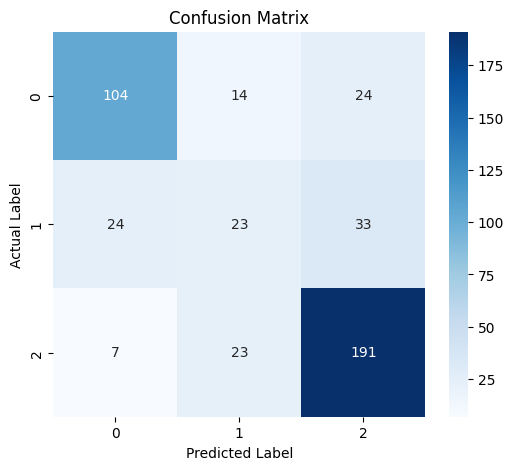

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_multi, multi_preds)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [38]:
# Create a DataFrame of confusion matrix values
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1", "Actual 2"], columns=["Predicted 0", "Predicted 1", "Predicted 2"])
display(cm_df)

# Identify most common misclassification
misclassifications = cm_df.subtract(np.diag(np.diag(cm_df)))  # Remove diagonal (correct predictions)
most_common_error = misclassifications.stack().idxmax()
print(f"Most common misclassification: {most_common_error[0]} → {most_common_error[1]}")


,Predicted 0,Predicted 1,Predicted 2
Actual 0,104,14,24
Actual 1,24,23,33
Actual 2,7,23,191


Most common misclassification: Actual 1 → Predicted 2


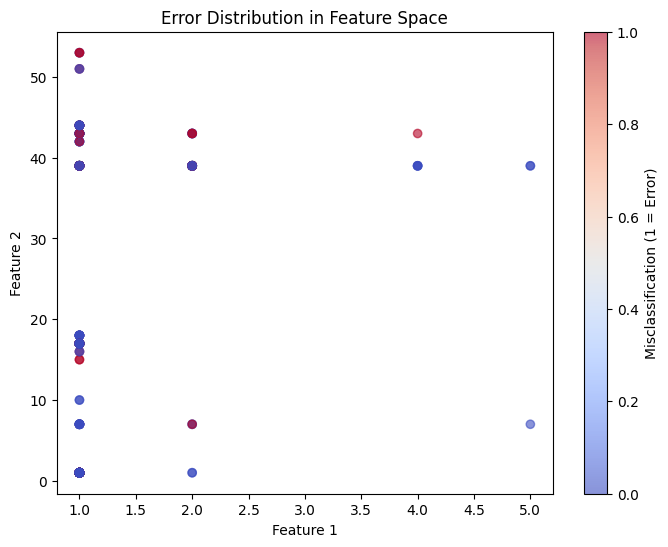

In [39]:
# Scatter plot of two main features, highlighting errors
plt.figure(figsize=(8,6))
plt.scatter(X_test_multi.iloc[:, 0], X_test_multi.iloc[:, 1], c=error_df["error"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Error Distribution in Feature Space")
plt.colorbar(label="Misclassification (1 = Error)")
plt.show()